In [3]:
# %% RF prediction cell — สร้าง df_out สำหรับใช้ต่อกับ helper plots
%matplotlib inline

import os
import numpy as np
import pandas as pd
import joblib
from sklearn.preprocessing import StandardScaler

# ------------- ปรับค่าตรงนี้ตามโปรเจคคุณ -------------
MODEL_PATH = "model/landsilde_rf_pipeline_best.joblib"   # path โมเดล RF ของคุณ
DATA_PATH  = "./../../data/dataSet2_prepared.csv"        # path ข้อมูล validation
DEVICE_FILTER = 103   # ถ้าไม่ต้องการกรอง ตั้ง None
FEATURE_COLS = ['soil','rain','temp','humi','geo']
OUT_DIR = "results"
os.makedirs(OUT_DIR, exist_ok=True)
label_map = {0:'Normal', 1:'Warning', 2:'Critical'}
# -------------------------------------------------------

# โหลดข้อมูล
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Data not found: {DATA_PATH}")
df = pd.read_csv(DATA_PATH)
print(f"Loaded data rows={len(df)} columns={list(df.columns)[:12]}")

# กรอง device ถ้าตั้งค่า
if DEVICE_FILTER is not None and 'devID' in df.columns:
    df = df[df['devID'] == DEVICE_FILTER].copy()
    print(f"Filtered devID == {DEVICE_FILTER}, rows -> {len(df)}")

# แปลง timestamp ถ้ามี
if 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# เตรียม features: เติมค่าว่างด้วย median ถ้าจำเป็น
for c in FEATURE_COLS:
    if c not in df.columns:
        df[c] = np.nan
X_df = df[FEATURE_COLS].fillna(df[FEATURE_COLS].median())
X = X_df.values

# โหลดโมเดล
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"RF model not found: {MODEL_PATH}")
rf_model = joblib.load(MODEL_PATH)
print(f"Loaded RF model from: {MODEL_PATH}")

# ทำการทำนาย
print("Running RF predict ...")
try:
    y_pred = rf_model.predict(X)
except Exception as e:
    raise RuntimeError(f"RF predict failed: {e}")

# พยายามดึง predict_proba (best-effort)
proba = None
try:
    proba = rf_model.predict_proba(X)
except Exception:
    # ถ้าเป็น pipeline ให้ลองเข้าถึง classifier ภายใน
    try:
        if hasattr(rf_model, 'named_steps') and 'clf' in rf_model.named_steps:
            clf = rf_model.named_steps['clf']
            scaler = rf_model.named_steps.get('scaler', None)
            X_in = scaler.transform(X) if scaler is not None else X
            if hasattr(clf, 'predict_proba'):
                proba = clf.predict_proba(X_in)
    except Exception:
        proba = None

# สร้าง df_out ใน scope
df_out = df.copy().reset_index(drop=True)
df_out['rf_pred'] = y_pred
# แมปเป็น label (ถ้าเป็น 0/1/2)
try:
    df_out['rf_pred_label'] = df_out['rf_pred'].map(label_map)
except Exception:
    df_out['rf_pred_label'] = df_out['rf_pred'].astype(str)

# ถ้ามี proba ให้สร้างคอลัมน์ proba_*
if proba is not None:
    # พยายามหา class order (เพื่อแมปคอลัมน์ proba ให้ถูก)
    classes_order = None
    try:
        classes_order = rf_model.classes_ if hasattr(rf_model, 'classes_') else (rf_model.named_steps['clf'].classes_ if hasattr(rf_model, 'named_steps') and 'clf' in rf_model.named_steps and hasattr(rf_model.named_steps['clf'], 'classes_') else None)
    except Exception:
        classes_order = None

    if classes_order is not None:
        for i, cls in enumerate(classes_order):
            lab = label_map.get(cls, str(cls))
            df_out[f'proba_{lab}'] = proba[:, i]
    else:
        # fallback สมมติ ordering เป็น [0,1,2]
        for i, lab in label_map.items():
            df_out[f'proba_{label_map[i]}'] = proba[:, i]

# บันทึกผลลัพธ์เบื้องต้น เพื่อความปลอดภัย
out_csv = os.path.join(OUT_DIR, "rf_validate_results.csv")
df_out.to_csv(out_csv, index=False)
print(f"Saved predictions -> {out_csv}")

# พิมพ์สรุปสั้น ๆ ให้เห็นว่า df_out ถูกสร้างแล้ว
print("\n=== RF prediction summary ===")
print("prediction counts:")
print(df_out['rf_pred_label'].value_counts())
if 'proba_Critical' in df_out.columns:
    print("\nproba_Critical stats:")
    print(df_out['proba_Critical'].describe())

# เลื่อนตัวแปรไปอยู่ใน namespace (Jupyter cell scope จะมี df_out อยู่แล้ว)
print("\nDone. คุณสามารถรัน helper plotting cell ต่อได้เลย (df_out อยู่ใน scope).")


Loaded data rows=89833 columns=['timestamp', 'devID', 'soil', 'rain', 'temp', 'humi', 'geo', 'lat', 'lng', 'iso_score', 'iso_risk', 'lstm_score']
Filtered devID == 103, rows -> 38673


c:\Users\ahmad\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\ahmad\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.7.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\ahmad\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle es

Loaded RF model from: model/landsilde_rf_pipeline_best.joblib
Running RF predict ...


c:\Users\ahmad\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Saved predictions -> results\rf_validate_results.csv

=== RF prediction summary ===
prediction counts:
rf_pred_label
Normal     38379
Warning      294
Name: count, dtype: int64

proba_Critical stats:
count    38673.000000
mean         0.000689
std          0.002544
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.076861
Name: proba_Critical, dtype: float64

Done. คุณสามารถรัน helper plotting cell ต่อได้เลย (df_out อยู่ใน scope).


df_out detected — ready to create RF plots



C:\Users\ahmad\AppData\Local\Temp\ipykernel_25744\1628451260.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=pred_col, order=order, palette=palette)


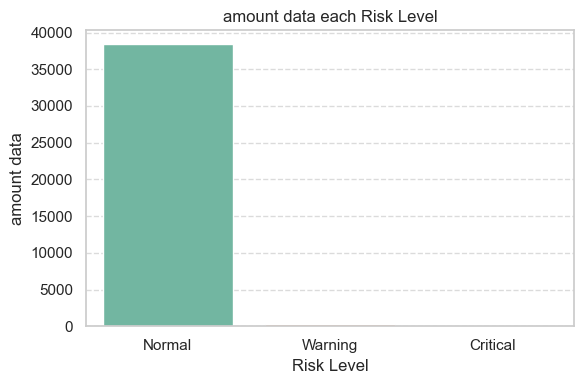

Saved -> results\rf_counts_by_risk.png

--- Critical group (n=0) ---
No rows.

--- Warning group (n=294) ---


,soil,rain,temp,humi,geo
count,294.000000,294.000000,294.000000,294.000000,294.000000
mean,18.619558,4.666804,24.111905,96.915022,11.765039
std,0.874546,3.969812,0.613370,1.068033,5.356075
min,17.200001,1.676400,23.200001,93.699997,2.618964
25%,17.400000,2.514600,23.662500,96.400002,8.086618
50%,18.750000,3.632200,23.950000,96.850002,11.004582
75%,19.100000,6.426200,24.600000,97.750000,14.298772
max,20.000000,36.321999,25.600000,98.300003,31.984940



--- Normal group (n=38379) ---


,soil,rain,temp,humi,geo
count,38379.000000,38379.000000,38379.000000,38379.000000,38379.000000
mean,18.370462,0.037425,28.093552,79.410923,6.648234
std,1.173438,0.362532,3.484368,13.397416,5.948229
min,0.000000,0.000000,6.550000,24.228929,0.192656
25%,17.299999,0.000000,25.200001,68.500000,2.478903
50%,18.500000,0.000000,26.700001,83.400002,4.395669
75%,19.450000,0.000000,31.200001,90.099998,11.080767
max,21.200001,35.763199,36.900002,98.599998,32.000000



== Mean Feature Values by Predicted Class ==


,soil,rain,temp,humi,geo
rf_pred_label,,,,,
Normal,18.370462,0.037425,28.093552,79.410923,6.648234
Warning,18.619558,4.666804,24.111905,96.915022,11.765039


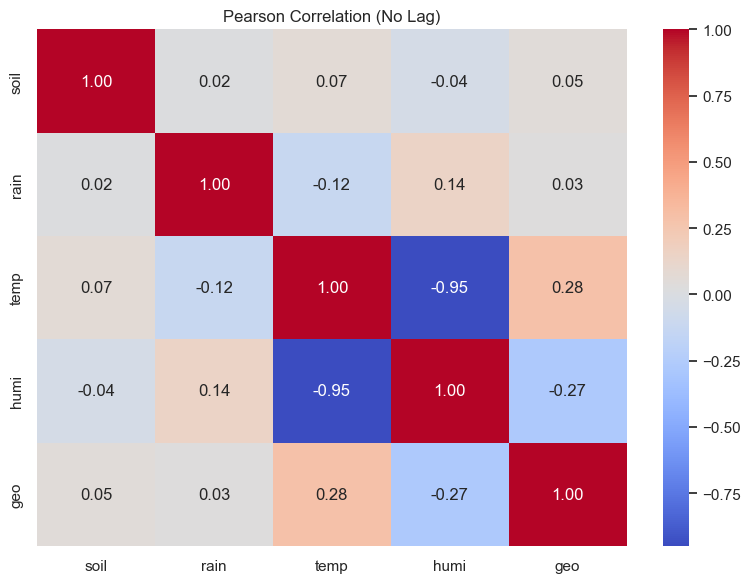

Saved -> results\rf_feature_correlation.png


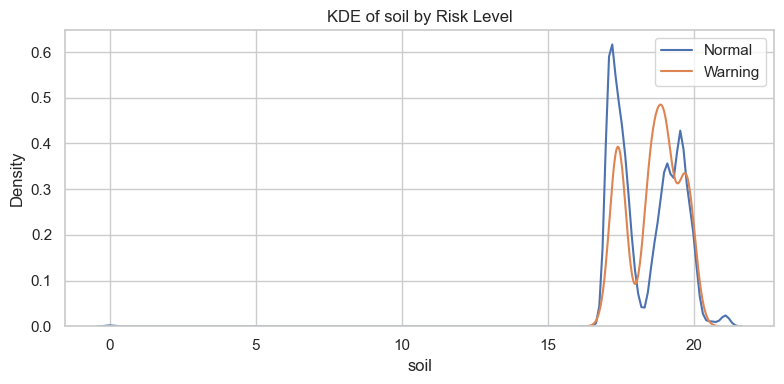

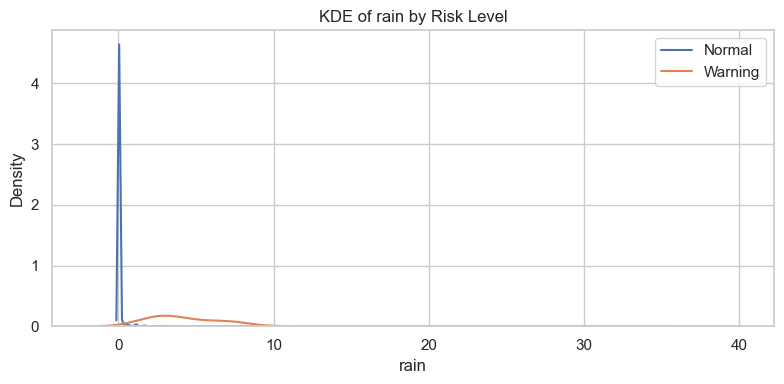

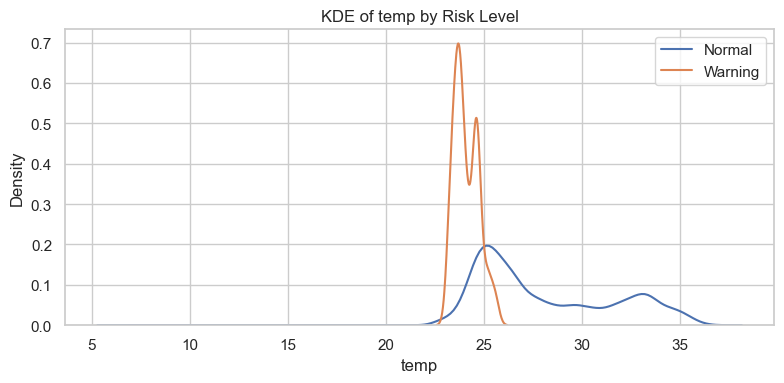

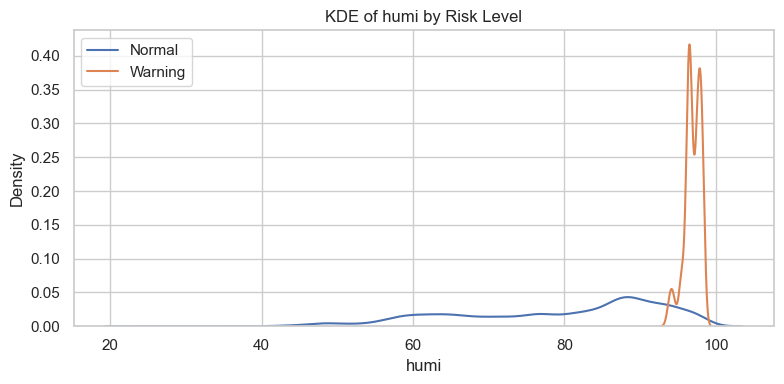

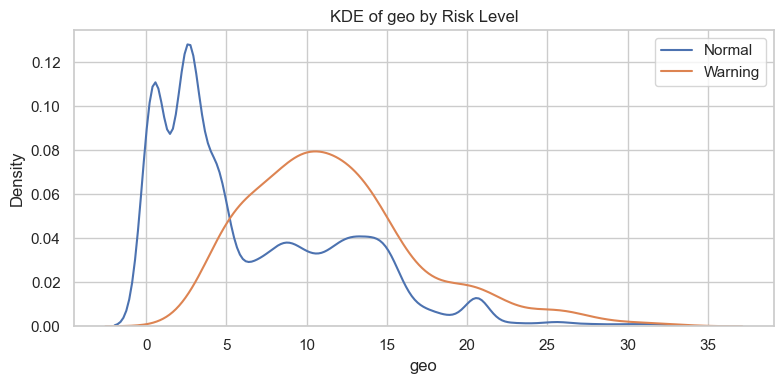

C:\Users\ahmad\AppData\Local\Temp\ipykernel_25744\1628451260.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=pred_col, y=col, data=df, order=order, palette='Set2')
C:\Users\ahmad\AppData\Local\Temp\ipykernel_25744\1628451260.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=pred_col, y=col, data=df, order=order, palette='Set2')
C:\Users\ahmad\AppData\Local\Temp\ipykernel_25744\1628451260.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=pred_col, y=col, data=df, order=order, palette='Set2')
C:\Users\ahmad\AppData\Local\Te

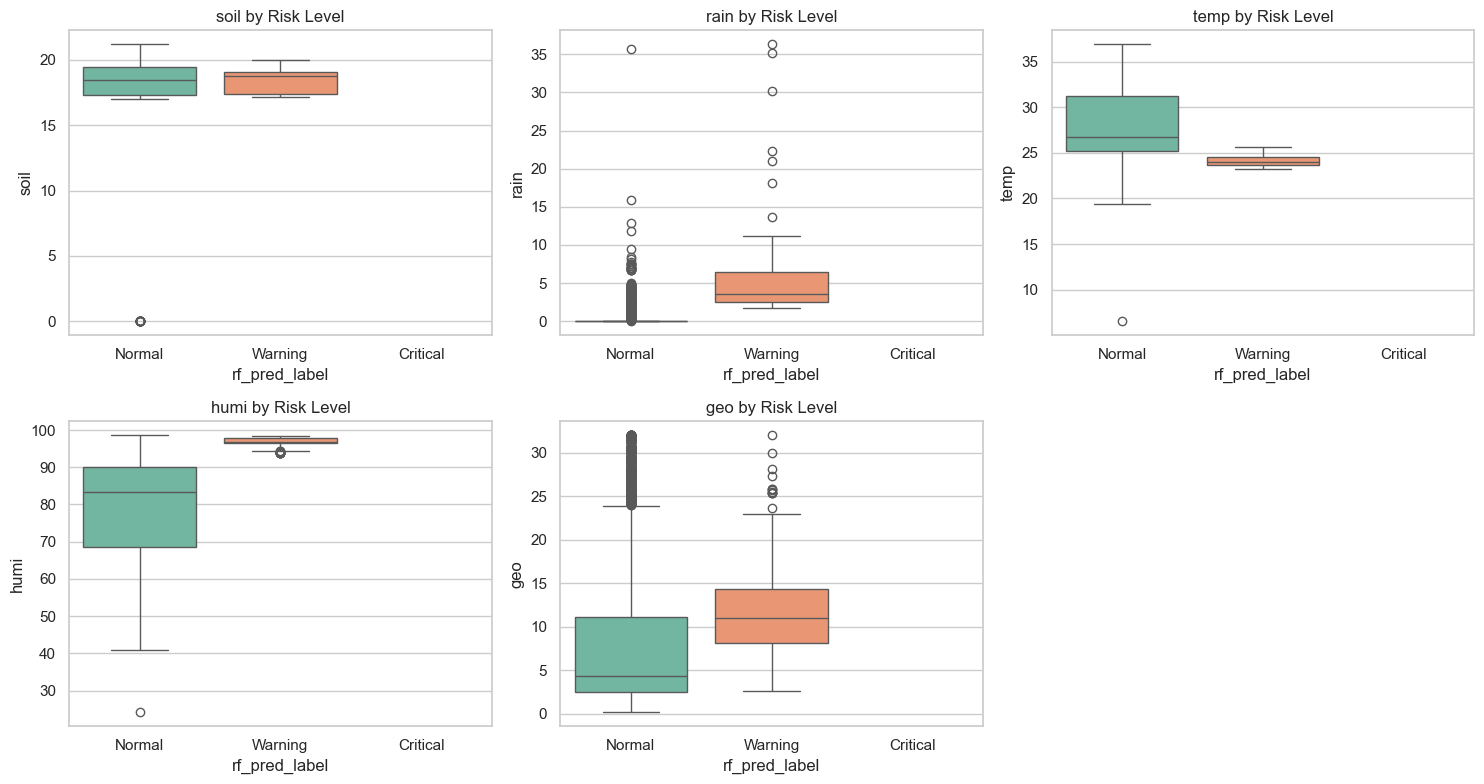

Saved -> results\rf_boxplots_by_risk.png


<Figure size 1200x500 with 0 Axes>

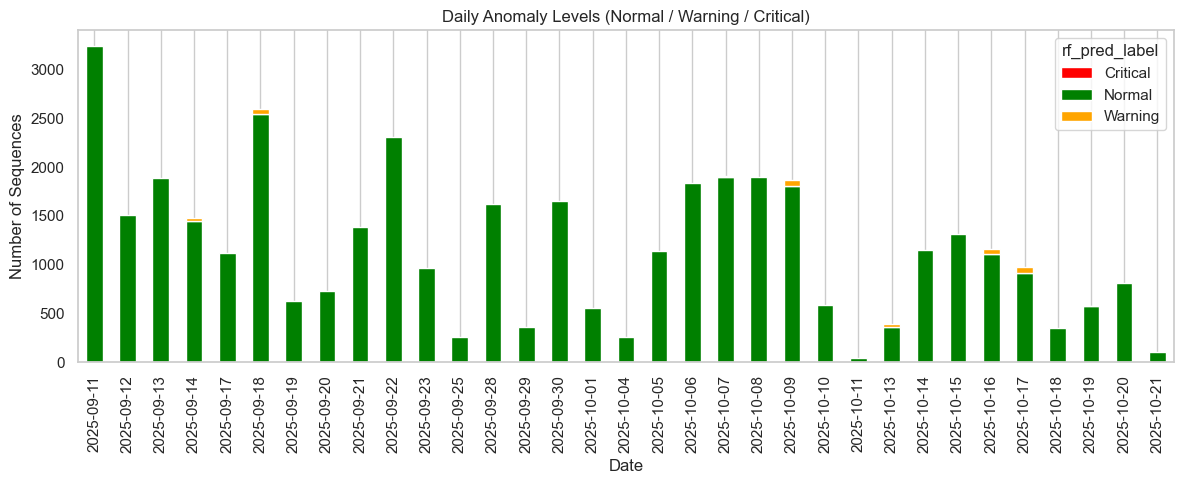

Saved -> results\rf_daily_predictions_stacked.png


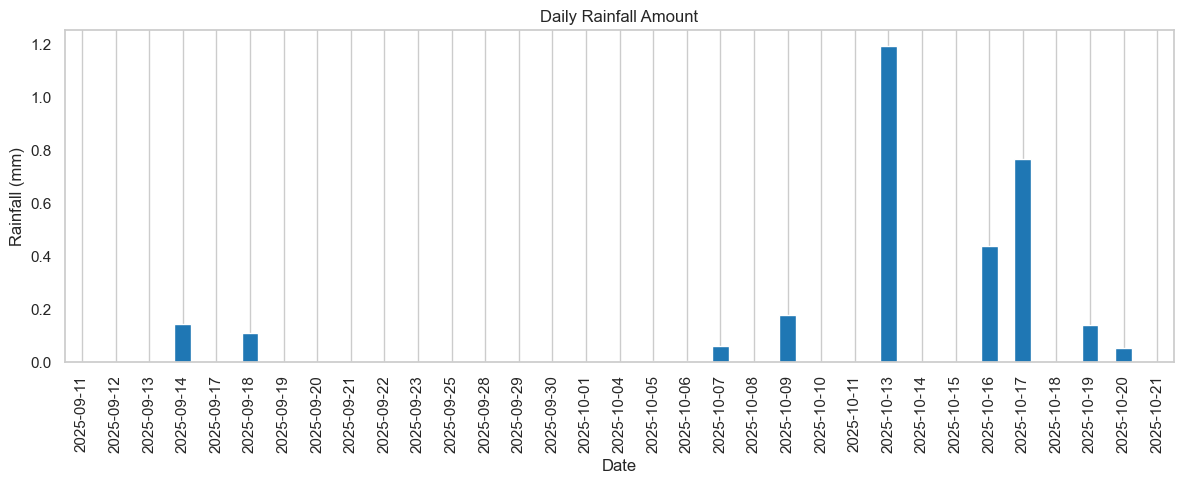

Saved -> results\rf_daily_rain.png


C:\Users\ahmad\AppData\Local\Temp\ipykernel_25744\1628451260.py:283: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


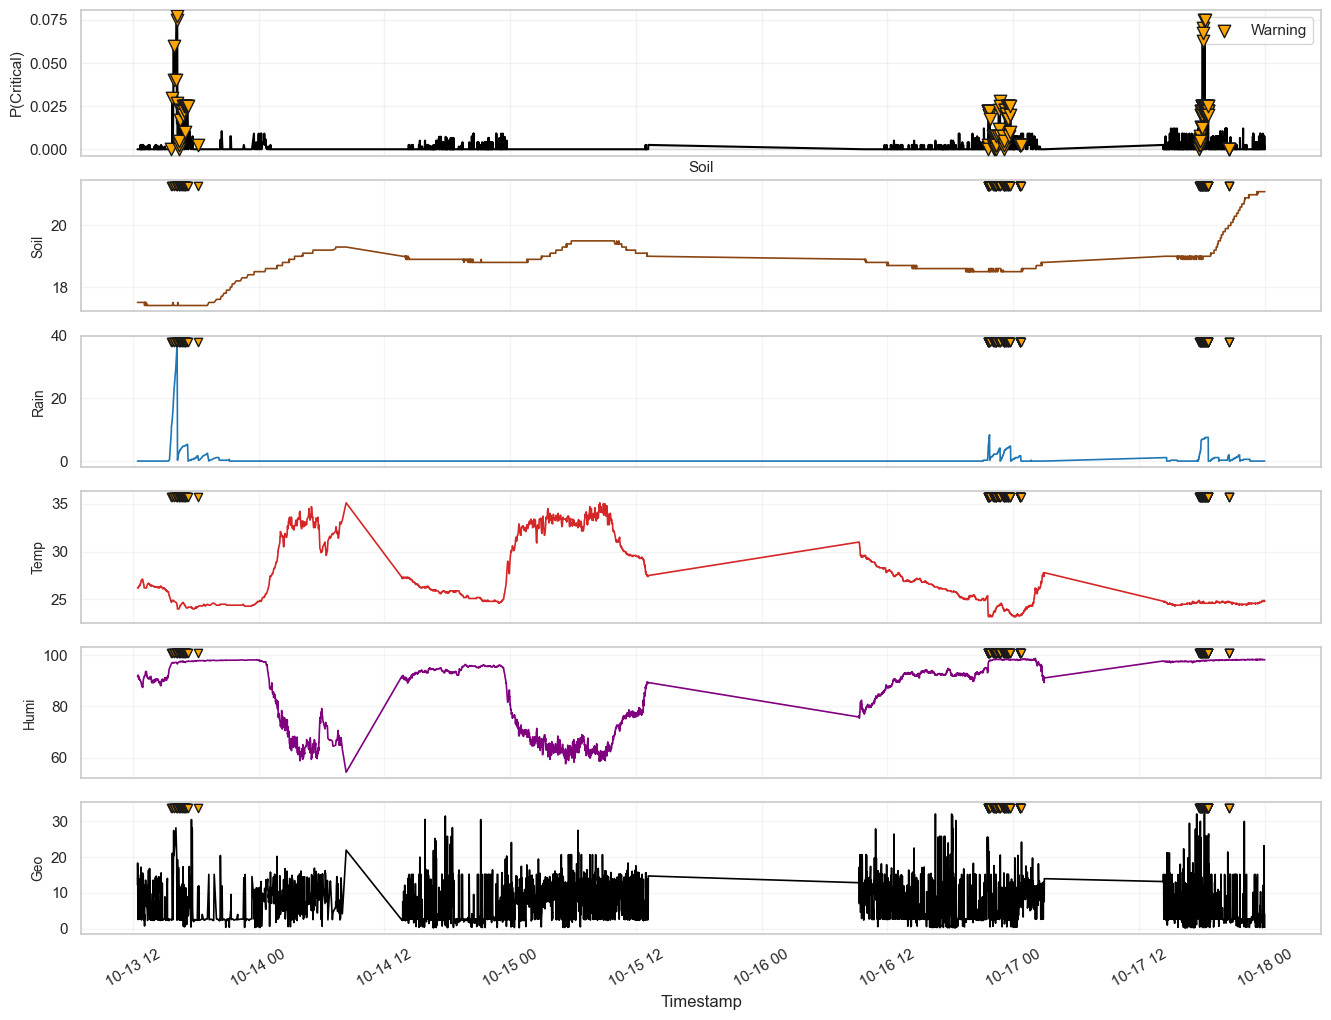

Saved -> results\rf_timeseries_subplot_marked.png


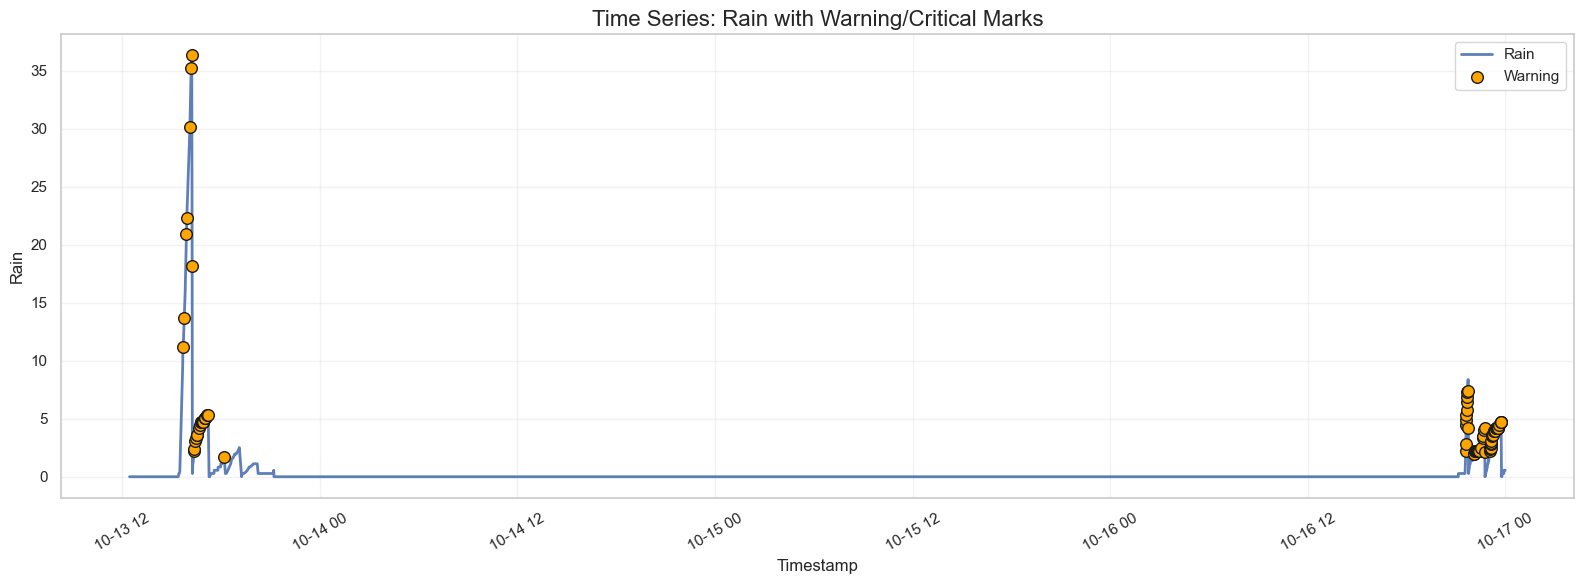

Saved -> results\rf_timeseries_rain_marks.png


In [4]:
# %% RF helper plots & summaries (full cell)
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Optional
from IPython.display import display

sns.set(style="whitegrid")

# -----------------------
# GLOBALS / DEFAULTS
# -----------------------
OUT_DIR = "results"
FEATURE_COLS = ['soil', 'rain', 'temp', 'humi', 'geo']
os.makedirs(OUT_DIR, exist_ok=True)

# -----------------------
# HELPERS
# -----------------------
def ensure_outdir(out_dir: str = OUT_DIR):
    os.makedirs(out_dir, exist_ok=True)

# -----------------------
# PLOTTING / SUMMARY FUNCTIONS
# -----------------------
def plot_prediction_counts(df: pd.DataFrame,
                           pred_col: str = 'rf_pred_label',
                           order: List[str] = ['Normal','Warning','Critical'],
                           palette='Set2',
                           out_dir: str = OUT_DIR):
    ensure_outdir(out_dir)
    if pred_col not in df.columns:
        print(f"[plot_prediction_counts] column '{pred_col}' not found")
        return
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x=pred_col, order=order, palette=palette)
    plt.title('amount data each Risk Level')
    plt.xlabel('Risk Level')
    plt.ylabel('amount data')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    p = os.path.join(out_dir, 'rf_counts_by_risk.png')
    plt.savefig(p)
    plt.show()
    print(f"Saved -> {p}")

def describe_groups_by_prediction(df: pd.DataFrame,
                                  feature_cols: List[str] = FEATURE_COLS,
                                  pred_col: str = 'rf_pred_label'):
    if pred_col not in df.columns:
        print(f"[describe_groups_by_prediction] column '{pred_col}' not found")
        return
    groups = {}
    for lab in ['Critical','Warning','Normal']:
        g = df[df[pred_col] == lab]
        groups[lab] = g[feature_cols].describe()
        print(f"\n--- {lab} group (n={len(g)}) ---")
        if len(g) > 0:
            display(groups[lab])
        else:
            print("No rows.")
    return groups

def mean_features_by_prediction(df: pd.DataFrame,
                                feature_cols: List[str] = FEATURE_COLS,
                                pred_col: str = 'rf_pred_label'):
    if pred_col not in df.columns:
        print(f"[mean_features_by_prediction] column '{pred_col}' not found")
        return
    print("\n== Mean Feature Values by Predicted Class ==")
    display(df.groupby(pred_col)[feature_cols].mean())

def correlation_heatmap(df: pd.DataFrame,
                        feature_cols: List[str] = FEATURE_COLS,
                        out_dir: str = OUT_DIR):
    ensure_outdir(out_dir)
    corr_matrix = df[feature_cols].corr()
    plt.figure(figsize=(8,6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Pearson Correlation (No Lag)")
    plt.tight_layout()
    p = os.path.join(out_dir, 'rf_feature_correlation.png')
    plt.savefig(p)
    plt.show()
    print(f"Saved -> {p}")

def kde_by_prediction(df: pd.DataFrame,
                      feature_cols: List[str] = FEATURE_COLS,
                      pred_col: str = 'rf_pred_label',
                      palette_map: dict = None,
                      out_dir: str = OUT_DIR):
    ensure_outdir(out_dir)
    if pred_col not in df.columns:
        print(f"[kde_by_prediction] column '{pred_col}' not found")
        return
    if palette_map is None:
        palette_map = {'Normal':'green','Warning':'orange','Critical':'red'}
    for col in feature_cols:
        plt.figure(figsize=(8,4))
        for lab, color in palette_map.items():
            if lab in df[pred_col].unique():
                sns.kdeplot(df[df[pred_col]==lab][col].dropna(), label=lab)
        plt.title(f"KDE of {col} by Risk Level")
        plt.legend(); plt.grid(True)
        plt.tight_layout()
        p = os.path.join(out_dir, f'rf_kde_{col}.png')
        plt.savefig(p)
        plt.show()
        plt.close()

def boxplot_features_by_prediction(df: pd.DataFrame,
                                   feature_cols: List[str] = FEATURE_COLS,
                                   pred_col: str = 'rf_pred_label',
                                   order: List[str] = ['Normal','Warning','Critical'],
                                   out_dir: str = OUT_DIR):
    ensure_outdir(out_dir)
    plt.figure(figsize=(15,8))
    for i, col in enumerate(feature_cols):
        plt.subplot(2, 3, i+1)
        sns.boxplot(x=pred_col, y=col, data=df, order=order, palette='Set2')
        plt.title(f'{col} by Risk Level')
    plt.tight_layout()
    p = os.path.join(out_dir, 'rf_boxplots_by_risk.png')
    plt.savefig(p)
    plt.show()
    print(f"Saved -> {p}")

def daily_stacked_predictions(df: pd.DataFrame,
                              pred_col: str = 'rf_pred_label',
                              timestamp_col: str = 'timestamp',
                              risk_order: List[str] = ['Critical','Normal','Warning'],
                              colors: List[str] = ['red','green','orange'],
                              out_dir: str = OUT_DIR):
    ensure_outdir(out_dir)
    if timestamp_col not in df.columns:
        print(f"[daily_stacked_predictions] no column '{timestamp_col}'")
        return
    df_tmp = df.copy()
    df_tmp['date'] = pd.to_datetime(df_tmp[timestamp_col]).dt.date
    alerts_per_day = df_tmp.groupby(['date', pred_col]).size().unstack(fill_value=0)
    for risk in risk_order:
        if risk not in alerts_per_day.columns:
            alerts_per_day[risk] = 0
    alerts_per_day = alerts_per_day[risk_order]
    plt.figure(figsize=(12,5))
    alerts_per_day.plot(kind='bar', stacked=True, figsize=(12,5), color=colors)
    plt.title("Daily Anomaly Levels (Normal / Warning / Critical)")
    plt.xlabel("Date"); plt.ylabel("Number of Sequences")
    plt.grid(axis='y'); plt.tight_layout()
    p = os.path.join(out_dir, 'rf_daily_predictions_stacked.png')
    plt.savefig(p)
    plt.show()
    print(f"Saved -> {p}")

def daily_rain_plot(df: pd.DataFrame,
                    timestamp_col: str = 'timestamp',
                    rain_col: str = 'rain',
                    out_dir: str = OUT_DIR):
    ensure_outdir(out_dir)
    if timestamp_col not in df.columns or rain_col not in df.columns:
        print(f"[daily_rain_plot] missing '{timestamp_col}' or '{rain_col}'")
        return
    df_tmp = df.copy()
    df_tmp['date'] = pd.to_datetime(df_tmp[timestamp_col]).dt.date
    rain_per_day = df_tmp.groupby('date')[rain_col].mean()
    plt.figure(figsize=(12,5))
    rain_per_day.plot(kind='bar', color='tab:blue')
    plt.title("Daily Rainfall Amount")
    plt.xlabel("Date"); plt.ylabel("Rainfall (mm)")
    plt.grid(axis='y'); plt.tight_layout()
    p = os.path.join(out_dir, 'rf_daily_rain.png')
    plt.savefig(p)
    plt.show()
    print(f"Saved -> {p}")

# -----------------------
# IMPROVED timeseries_subplot_marked (cleaner, larger, nicer legend)
# -----------------------
def timeseries_subplot_marked(df: pd.DataFrame,
                              start: str = None,
                              end: str = None,
                              timestamp_col: str = 'timestamp',
                              feature_cols: list = FEATURE_COLS,
                              pred_col: str = 'rf_pred_label',
                              proba_col: str = 'proba_Critical',   # ถ้ามี probability ของ Critical
                              window_size: int = 25,
                              out_dir: str = OUT_DIR):
    """
    วาด subplot แบบ ISO-style แต่เป็น RF และ *mark* จุดที่เป็น Warning / Critical
    - ออกแบบให้ดูสะอาด: ช่องใหญ่, marker ชัด, legend อ่านง่าย
    - ถ้ามี proba_col จะวาดเส้น P(Critical) และ mark จุด Warning/Critical ตาม timestamp
    - ถ้าไม่มี proba_col จะวาด encoded prediction (0,1,2) และ mark จุด Warning/Critical
    """
    ensure_outdir(out_dir)
    if timestamp_col not in df.columns:
        print(f"[timeseries_subplot_marked] missing '{timestamp_col}'")
        return

    df_ts = df.copy()
    df_ts[timestamp_col] = pd.to_datetime(df_ts[timestamp_col])
    df_ts = df_ts.set_index(timestamp_col).sort_index()

    if start is not None or end is not None:
        df_ts = df_ts.loc[start:end]

    if df_ts.empty:
        print("[timeseries_subplot_marked] empty date range")
        return

    # prepare masks
    warn_mask = (df_ts[pred_col] == 'Warning') if pred_col in df_ts.columns else pd.Series(False, index=df_ts.index)
    crit_mask = (df_ts[pred_col] == 'Critical') if pred_col in df_ts.columns else pd.Series(False, index=df_ts.index)

    # Figure layout: taller, two main areas (prob/pred) + 4 feature rows
    n_subplots = 6
    fig, axs = plt.subplots(n_subplots,1, figsize=(16, 12), sharex=True,
                             gridspec_kw={'height_ratios':[1.0, 0.9, 0.9, 0.9, 0.9, 0.9], 'hspace':0.18})

    # --- Top: probability OR encoded predictions ---
    if proba_col in df_ts.columns:
        axs[0].plot(df_ts.index, df_ts[proba_col], color='black', linewidth=1.5)
        axs[0].fill_between(df_ts.index, 0, df_ts[proba_col], color='black', alpha=0.06)
        axs[0].set_ylabel("P(Critical)", fontsize=11)
        # mark warning/critical at their proba values
        if warn_mask.any():
            axs[0].scatter(df_ts.loc[warn_mask].index, df_ts.loc[warn_mask, proba_col],
                           marker='v', s=80, label='Warning', color='orange', edgecolor='k', zorder=6)
        if crit_mask.any():
            axs[0].scatter(df_ts.loc[crit_mask].index, df_ts.loc[crit_mask, proba_col],
                           marker='^', s=110, label='Critical', color='red', edgecolor='k', zorder=7)
        axs[0].legend(frameon=True, fontsize=11, loc='upper right')
    else:
        # encoded predictions (0,1,2) with markers for warn/crit
        mapping = {'Normal':0, 'Warning':1, 'Critical':2}
        if pred_col in df_ts.columns:
            enc = df_ts[pred_col].map(mapping).fillna(-1)
            axs[0].scatter(df_ts.index, enc, c=enc, cmap='coolwarm', s=18, zorder=2)
            axs[0].set_ylabel("RF Pred (0=N,1=W,2=C)", fontsize=11)
            if warn_mask.any():
                axs[0].scatter(df_ts.loc[warn_mask].index, enc.loc[warn_mask],
                               marker='v', s=80, color='orange', edgecolor='k', zorder=6, label='Warning')
            if crit_mask.any():
                axs[0].scatter(df_ts.loc[crit_mask].index, enc.loc[crit_mask],
                               marker='^', s=110, color='red', edgecolor='k', zorder=7, label='Critical')
            axs[0].legend(frameon=True, fontsize=11, loc='upper right')
        else:
            axs[0].text(0.5, 0.5, "No prediction column found", ha='center', fontsize=12)

    axs[0].grid(alpha=0.25)

    # --- Subsequent plots: features (soil, rain, temp, humi, geo) ---
    plot_order = feature_cols[:5] if feature_cols is not None else FEATURE_COLS
    colors = {'soil':'saddlebrown','rain':'tab:blue','temp':'tab:red','humi':'purple','geo':'black'}

    # Ensure plotting only existing columns; match axs[1]..axs[5]
    for i, col in enumerate(plot_order):
        ax = axs[i+1]
        if col in df_ts.columns:
            ax.plot(df_ts.index, df_ts[col], color=colors.get(col,'tab:gray'), linewidth=1.2)
            ax.set_ylabel(col.capitalize(), fontsize=10)
            ax.set_title(col.capitalize() if i==0 else None, fontsize=11)
            ax.grid(alpha=0.2)
            # draw small marker triangles at top for warn/crit
            ylim = ax.get_ylim()
            y_top = ylim[1]
            if warn_mask.any():
                ax.scatter(df_ts.loc[warn_mask].index, [y_top]*warn_mask.sum(),
                           marker='v', s=36, color='orange', edgecolor='k', zorder=8)
            if crit_mask.any():
                ax.scatter(df_ts.loc[crit_mask].index, [y_top]*crit_mask.sum(),
                           marker='^', s=45, color='red', edgecolor='k', zorder=9)
        else:
            ax.text(0.5, 0.5, f"No column '{col}'", ha='center')

    # final touches
    axs[-1].set_xlabel("Timestamp", fontsize=12)
    for ax in axs:
        ax.tick_params(axis='x', labelrotation=30)
    plt.tight_layout()
    out_path = os.path.join(out_dir, 'rf_timeseries_subplot_marked.png')
    plt.savefig(out_path, dpi=150)
    plt.show()
    print(f"Saved -> {out_path}")

# -----------------------
# Nicely styled single-feature plot with marks
# -----------------------
def plot_timeseries_with_marks(df: pd.DataFrame,
                               feature: str = 'rain',
                               pred_col: str = 'rf_pred_label',
                               warn_label: str = 'Warning',
                               crit_label: str = 'Critical',
                               start: Optional[str] = None,
                               end: Optional[str] = None,
                               out_dir: str = OUT_DIR):
    """
    สวยและเรียบ: plot single-feature time series และ mark Warning/Critical
    """
    ensure_outdir(out_dir)
    df_plot = df.copy()
    if 'timestamp' in df_plot.columns:
        df_plot['timestamp'] = pd.to_datetime(df_plot['timestamp'])
    if start:
        df_plot = df_plot[df_plot['timestamp'] >= pd.to_datetime(start)]
    if end:
        df_plot = df_plot[df_plot['timestamp'] <= pd.to_datetime(end)]

    plt.figure(figsize=(16,6))
    sns.lineplot(x='timestamp', y=feature, data=df_plot, linewidth=2, alpha=0.9, label=feature.capitalize())
    # markers
    if pred_col in df_plot.columns:
        warn = df_plot[df_plot[pred_col] == warn_label]
        crit = df_plot[df_plot[pred_col] == crit_label]
        if not warn.empty:
            plt.scatter(warn['timestamp'], warn[feature], color='orange', edgecolor='k', s=70, label='Warning', zorder=5)
        if not crit.empty:
            plt.scatter(crit['timestamp'], crit[feature], color='red', edgecolor='k', s=90, label='Critical', zorder=6)
    plt.title(f"Time Series: {feature.capitalize()} with Warning/Critical Marks", fontsize=16)
    plt.xlabel("Timestamp"); plt.ylabel(feature.capitalize())
    plt.legend(frameon=True)
    plt.grid(alpha=0.25)
    plt.xticks(rotation=30)
    plt.tight_layout()
    p = os.path.join(out_dir, f'rf_timeseries_{feature}_marks.png')
    plt.savefig(p, dpi=150)
    plt.show()
    print(f"Saved -> {p}")

# -----------------------
# USAGE EXAMPLES (uncomment to run)
# -----------------------
# หลังรัน RF prediction cell แล้วจะมี df_out เป็น DataFrame ของคุณ
try:
    _ = df_out  # ตรวจว่ามีตัวแปร df_out อยู่
    print("df_out detected — ready to create RF plots\n")
except NameError:
    print("กรุณารัน RF prediction cell ก่อน แล้วให้ df_out อยู่ใน scope (df_out ต้องมีคอลัมน์ 'rf_pred_label')")

# ตัวอย่างเรียกใช้ (เอา comment ออกตามที่ต้องการ):
plot_prediction_counts(df_out)
describe_groups_by_prediction(df_out, FEATURE_COLS)
mean_features_by_prediction(df_out, FEATURE_COLS)
correlation_heatmap(df_out, FEATURE_COLS)
kde_by_prediction(df_out, FEATURE_COLS)
boxplot_features_by_prediction(df_out, FEATURE_COLS)
daily_stacked_predictions(df_out)
daily_rain_plot(df_out)
timeseries_subplot_marked(df_out, start="2025-10-13", end="2025-10-17", proba_col='proba_Critical')
plot_timeseries_with_marks(df_out, feature='rain', start="2025-10-13", end="2025-10-17")